# Imports

Import necessary libraries and modules including:
| Libraries | Version | Channel |
| ----------- | ----------- | ----------- |
| Matplotlib | 3.9.1 | conda-forge |
| NumPy | 2.2.2 | conda-forge |
| Matplotlib | 3.9.1 | conda-forge |
| Pandas | 2.2.3 | conda-forge |
| Pillow | 9.4.0 | conda-forge |
| Pytorch | 2.5.1 | conda-forge |
| Seaborn | 0.13.2 | conda-forge |
| Sklearn | 1.6.1 | conda-forge |

In [79]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
import torchvision.transforms as transforms

from PIL import Image
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR


# Variables

For the sake of simpleness, the essentail constants are listed down below.

In [80]:
# Torch seed (for reproducibility purpose)
SEED = 33

In [81]:
# Dataset paths
dataset_path = "../dataset"
train_csv_path = "../dataset/train.csv"
test_csv_path = "../dataset/test.csv"

In [82]:
# Training varaibles
BATCH_SIZE = 32 # Number of images per batch
EPOCH = 50 # Epoch size
TRAIN_SIZE = 0.95 # 90 % of the training data is used for model training
VAL_SIZE = 0.05 # 10 % of the training data is used for model validation
LEARNING_RATE = 0.0001 # Model's learning rate (default = 0.001)
NUM_WORKERS = 12 # Number of CPU cores used for dataloader
MOMENTUM = 0.9 # Momentum for optimizer
PATIENCE = 5 # Early stopping monitor patience

# Image information
image_info = {
    # Both width and height are usually equal
    "width": 256,
    "height": 256
}

# Training data labels map
labels_map = {
    0: "Human",
    1: "AI"
}

In [83]:
# Display variables
display_figure_info = {
    "width": 12,
    "height": 12,
    "row": 3,
    "column": 3
}

In [84]:
# Current model
def get_current_model_path(new_model=False):
    count = 1

    while (True):
        if (os.path.isfile("../../trained_models/models/convnext/trained_model_" + f"{count}" + ".pth") == False):
            if (new_model):
                return "../../trained_models/models/convnext/trained_model_" + f"{count}" + ".pth"
            else:
                return "../../trained_models/models/convnext/trained_model_" + f"{count - 1}" + ".pth"
        else:
            count += 1

# Data Preprocessing

TODO: methods

In [85]:
torch.cuda.empty_cache() # Free CUDA cache memory
torch.manual_seed(SEED) # Assign Pytorch seed for reproducibility
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Initiate a CUDA device instance, if exists

In [86]:
# loading annotation files
train_csv = pd.read_csv(train_csv_path)
test_csv = pd.read_csv(test_csv_path)

In [87]:
# Print shapes of the splits
print(f"Train csv size: {train_csv.size}")
print(f"Test csv size: {test_csv.size}")

Train csv size: 239850
Test csv size: 5540


In [88]:
train_csv.head()

,Unnamed: 0,file_name,label
0,0,train_data/a6dcb93f596a43249135678dfcfc17ea.jpg,1
1,1,train_data/041be3153810433ab146bc97d5af505c.jpg,0
2,2,train_data/615df26ce9494e5db2f70e57ce7a3a4f.jpg,1
3,3,train_data/8542fe161d9147be8e835e50c0de39cd.jpg,0
4,4,train_data/5d81fa12bc3b4cea8c94a6700a477cf2.jpg,1


In [89]:
test_csv.head()

,id
0,test_data_v2/1a2d9fd3e21b4266aea1f66b30aed157.jpg
1,test_data_v2/ab5df8f441fe4fbf9dc9c6baae699dc7.jpg
2,test_data_v2/eb364dd2dfe34feda0e52466b7ce7956.jpg
3,test_data_v2/f76c2580e9644d85a741a42c6f6b39c0.jpg
4,test_data_v2/a16495c578b7494683805484ca27cf9f.jpg


In [90]:
# Preprocess column names for consistency
train_csv = train_csv[["file_name", "label"]]
train_csv.columns = ["id", "label"]

In [91]:
# Split the training data into training and validation sets
train_df, val_df = train_test_split(
    train_csv,  
    test_size=0.05,   
    stratify=train_csv["label"] 
)

In [92]:
# Display columns for reference
print("Train columns:", train_csv.columns)
print("Test columns:", test_csv.columns)

# Print shapes of the splits
print(f"\nTrain shape: {train_df.shape}")
print(f"Validation shape: {val_df.shape}")

# Check class distribution in both sets
print("\nTrain class distribution:")
print(train_df["label"].value_counts(normalize=True))

print("\nValidation class distribution:")
print(val_df["label"].value_counts(normalize=True))

Train columns: Index(['id', 'label'], dtype='object')
Test columns: Index(['id'], dtype='object')

Train shape: (75952, 2)
Validation shape: (3998, 2)

Train class distribution:
label
0    0.5
1    0.5
Name: proportion, dtype: float64

Validation class distribution:
label
1    0.5
0    0.5
Name: proportion, dtype: float64


In [93]:
# Training augmentations
train_transforms = transforms.Compose([
    transforms.Resize(232),  # Resize to match ConvNeXt preprocessing
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Validation and Test transforms
val_test_transforms = transforms.Compose([
    transforms.Resize(232),  # Resize to 232 as per ConvNeXt documentation
    transforms.CenterCrop(224), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [94]:
# Dataset class for training and validation
class CustomTrainImageDataset(Dataset):
    def __init__(self, dataframe, root_dir, transform=None):
        self.dataframe = dataframe
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.dataframe.iloc[idx, 0])
        image = Image.open(img_name).convert("RGB")
        
        if self.transform:
            image = self.transform(image)
        
        label = self.dataframe.iloc[idx, 1]
        return image, label

# Dataset class for inference (validation and test)
class CustomTestImageDataset(Dataset):
    def __init__(self, file_list, transform=None):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, os.path.basename(img_path)

In [95]:
# Create datasets
train_dataset = CustomTrainImageDataset(train_df, root_dir=dataset_path, transform=train_transforms)
val_dataset = CustomTrainImageDataset(val_df, root_dir=dataset_path, transform=val_test_transforms) 

# For testing, create a list of file paths (id)
test_file_list = [os.path.join(dataset_path, fname) for fname in test_csv["id"]]
val_dataset = CustomTestImageDataset(file_list=test_file_list, transform=val_test_transforms)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
test_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

In [96]:
# Display datasets' information
print(f"Training dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(val_dataset)}")

Training dataset size: 75952
Validation dataset size: 3998
Test dataset size: 5540


In [97]:
# Load pretrained ConvNeXt Base model
model = models.convnext_base(weights="DEFAULT")

# Freeze the backbone
for param in model.features.parameters():
    param.requires_grad = False

# Replace the classifier head with a custom one
model.classifier = nn.Sequential(
    nn.AvgPool2d(kernel_size=3, padding=1, stride=3),  
    nn.Flatten(),                 
    nn.Linear(1024, 512),         
    nn.ReLU(),                    
    nn.Dropout(0.4),  
    nn.Linear(512, 256),         
    nn.ReLU(),                    
    nn.Dropout(0.4),  
    nn.Linear(256, 128),         
    nn.ReLU(),                    
    nn.Dropout(0.4),
    nn.Linear(128, 2),              
)


In [98]:
# Move the model to gpu
model = model.to(device)

In [ ]:
# Define loss function, optimizer, and learning rate scheduler
loss_function = nn.CrossEntropyLoss() # Implement crossentropy loss
optimizer = torch.optim.AdamW(model.classifier.parameters(), lr=LEARNING_RATE) # AdamW
# optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4) # Initialize an optimizer
scheduler = StepLR(optimizer, step_size=3, gamma=0.6)

In [100]:
# Early stopping monitor
class EarlyStopping:
    def __init__(self, patience=3, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = float("inf")
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

In [101]:
def train_loop(dataloader, model, loss_function, optimizer, val_loader=None, early_stopping=None, scheduler=None):
    model.train()
    
    all_predictions = [] # all predictions from the training model after each epoch
    all_labels = [] # all predictions from the training model after each epoch
    train_losses = [] # Array of training losses in each epoch
    lowest_val_loss = 1 # The lowest validation loss after an epoch
    val_losses = [] # Array of validation losses for plotting graph
    val_accuracies = [] # Array of validation accuracies for plotting graph

    current_model_path = get_current_model_path(new_model=True)

    progress_bar_length = 64 # Total number of "#" in the progress bar
    
    for epoch in range(EPOCH):
        progress_accumulated = 0.0 # Fractional progress tracker
        total_hashes = 0 # Total "#" printed so far

        print(f"Training epoch: {epoch + 1}")
        
        running_loss = 0.0
        correct = 0
        total = 0
        
        for i, data in enumerate(dataloader):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            # Collecting labels and predictions for classification report
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            # Update progress bar
            progress_accumulated, total_hashes = progress_bar(
                dataloader, progress_accumulated, total_hashes, progress_bar_length
            )

        # After epoch completes, ensure the progress bar shows 100%
        if total_hashes < progress_bar_length:
            bar = "#" * progress_bar_length
            print(f"Completion (100.00%) : [{bar}]", flush=True)
        else:
            print()  # Move to new line

        epoch_loss = running_loss / len(dataloader)
        accuracy = 100 * correct / total
        
        # Save epoch loss and accuracy
        train_losses.append(epoch_loss)
        
        print(f"\nTraining Loss: {epoch_loss:.4f}, Training Accuracy: {accuracy:.2f}%")
        
        if val_loader:
            val_loss, val_accuracy = validate_model(val_loader, model, loss_function)
            val_losses.append(val_loss)
            val_accuracies.append(val_accuracy)

            print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

            save_best_model(lowest_val_loss, val_loss, current_model_path)

            if (val_loss <= lowest_val_loss):
                lowest_val_loss = val_loss

            if early_stopping:
                early_stopping(val_loss)
                if early_stopping.early_stop:
                    print("Early stopping triggered.")
                    break
                
        # Call the scheduler to update the learning rate after each epoch
        if scheduler:
            scheduler.step()

        print("\n", end="\r")

    if val_loader:
        return train_losses, all_predictions, all_labels, val_losses, val_accuracies
    else:
        return train_losses, all_predictions, all_labels

def validate_model(dataloader, model, loss_function):
    model.eval()
    
    correct = 0
    total = 0
    val_loss = 0.0  
    
    with torch.no_grad():
        for data in dataloader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            val_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    accuracy = 100 * correct / total
    
    return val_loss / len(dataloader), accuracy

def progress_bar(dataloader, accumulated, total_hashes, progress_bar_length):
    total_batches = len(dataloader)
    if total_batches == 0:
        return accumulated, total_hashes
    
    # Calculate progress increment per batch
    progress_per_batch = progress_bar_length / total_batches
    accumulated += progress_per_batch # Add progress for current batch
    
    num_prints = int(accumulated) # Number of "#" to add now
    if num_prints > 0:
        total_hashes += num_prints
        accumulated -= num_prints # Reset accumulated
        
        # Cap at 100% to avoid overshooting
        if total_hashes > progress_bar_length:
            total_hashes = progress_bar_length
        
        # Calculate percentage and print
        percentage = (total_hashes / progress_bar_length) * 100
        bar = "=" * (total_hashes - 1)

        print(f"Completion ({percentage:.2f}%) : [{bar}>]", end="\r", flush=True)
    
    return accumulated, total_hashes

# If the file exists already, change the number behind the file
def save_best_model(lowest_val_loss, current_val_loss, current_model_path):
    if (current_val_loss < lowest_val_loss):
        torch.save(model.state_dict(), current_model_path) # save the trained model

In [102]:
torch.cuda.empty_cache() # Free CUDA cache memory

if val_loader:
    epoch_losses, all_preds, all_labels, val_losses, val_accuracies = train_loop(
        dataloader=train_loader,
        model=model,
        loss_function=loss_function,
        optimizer=optimizer,
        val_loader=val_loader,
        early_stopping=EarlyStopping(patience=PATIENCE)
    )
else:   
    epoch_losses, all_preds, all_labels = train_loop(
        dataloader=train_loader,
        model=model,
        loss_function=loss_function,
        optimizer=optimizer,
        early_stopping=EarlyStopping(patience=PATIENCE)
    )

Training epoch: 1
Completion (100.00%) : [===============================================================>]

Training Loss: 0.2555, Training Accuracy: 89.65%
Validation Loss: 0.1388, Validation Accuracy: 94.77%

Training epoch: 2
Completion (100.00%) : [===============================================================>]

Training Loss: 0.1391, Training Accuracy: 94.54%
Validation Loss: 0.0916, Validation Accuracy: 96.10%

Training epoch: 3
Completion (100.00%) : [===============================================================>]

Training Loss: 0.1119, Training Accuracy: 95.57%
Validation Loss: 0.0769, Validation Accuracy: 97.10%

Training epoch: 4
Completion (100.00%) : [===============================================================>]

Training Loss: 0.0980, Training Accuracy: 96.16%
Validation Loss: 0.0795, Validation Accuracy: 96.85%

Training epoch: 5
Completion (100.00%) : [===============================================================>]

Training Loss: 0.0883, Training Accuracy: 9

In [103]:
pd.read_csv('../../submission/submission.csv')["label"].value_counts()

label
1    5007
0     533
Name: count, dtype: int64

# Evaluating the Model

Evaluate and visualize the trained model's performance using validation set.

In [104]:
current_model_path = get_current_model_path()

In [105]:
# Load pretrained ConvNeXt Base model
model = models.convnext_base(weights="DEFAULT")

# Freeze the backbone
for param in model.features.parameters():
    param.requires_grad = False

# Replace the classifier head with a custom one
model.classifier = nn.Sequential(
    nn.AvgPool2d(kernel_size=3, padding=1, stride=3),   
    nn.Flatten(),                 
    nn.Linear(1024, 512),         
    nn.ReLU(),                    
    nn.Dropout(0.4),  
    nn.Linear(512, 256),         
    nn.ReLU(),                    
    nn.Dropout(0.4),  
    nn.Linear(256, 128),         
    nn.ReLU(),                    
    nn.Dropout(0.4),
    nn.Linear(128, 2),              
)

# Load model
model.load_state_dict(torch.load(current_model_path)) # load the trained model
model = model.to(device)

/tmp/ipykernel_142851/486502235.py:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(current_model_path)) # load the trained model


In [106]:
correct = 0 # number of correct predictions
total = 0 # number of total predictions

In [107]:
def load_image(image_path):
    image = Image.open(image_path)
    image = val_test_transforms(image)
    image = image.unsqueeze(0)

    return image.to(device)

In [108]:
test_image_paths = [
    "../../res/test_images/test_1.jpg",
    "../../res/test_images/test_2.jpg",
    "../../res/test_images/test_3.jpg",
    "../../res/test_images/test_4.jpg",
    "../../res/test_images/test_5.jpg",
    "../../res/test_images/test_6.jpg",
    "../../res/test_images/test_7.jpg",
    "../../res/test_images/test_8.jpg",
    "../../res/test_images/test_9.jpg",
]

images = [load_image(img) for img in test_image_paths]

In [109]:
model.eval()
prediction_labels = []

with torch.no_grad():
    for img in images:
        outputs = model(img)
        _, predicted = torch.max(outputs, 1)
        prediction_labels.append(predicted.item())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.5877128].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8610327..2.622571].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0836544..2.4134207].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0665298..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping

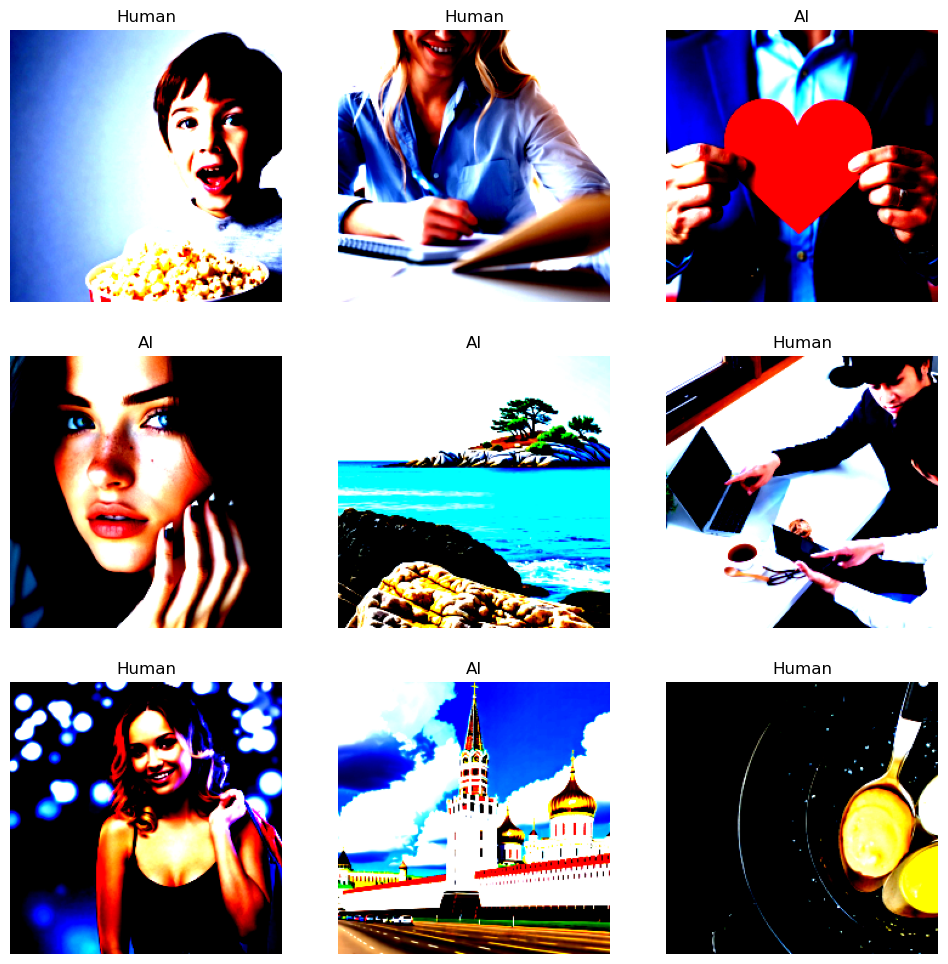

In [110]:
figure = plt.figure(figsize=(display_figure_info["width"], display_figure_info["height"]))

for i in range(1, display_figure_info["row"] * display_figure_info["column"] + 1):
    image_index = (i - 1) % len(images)
    image = images[image_index].cpu().squeeze(0).permute(1, 2, 0)
    label = prediction_labels[image_index]

    figure.add_subplot(display_figure_info["row"], display_figure_info["column"], i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(image)

plt.show()

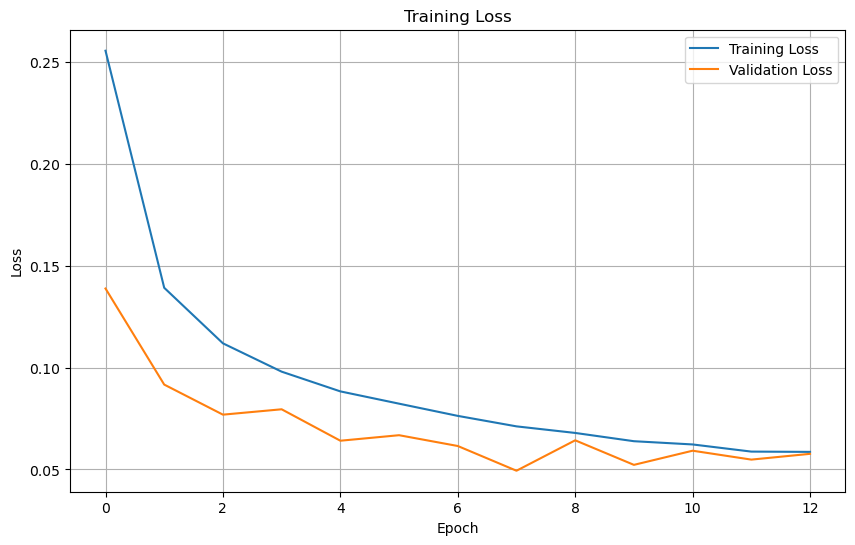

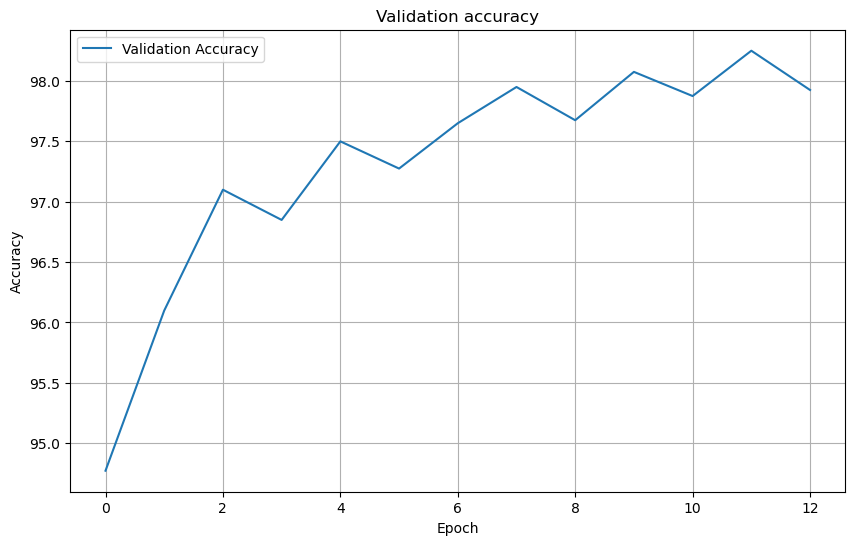

Final Training Accuracy: 96.24%


In [111]:
# Loss graph
plt.figure(figsize=(10, 6))
plt.plot(epoch_losses, label="Training Loss") # Training loss
plt.plot(val_losses, label="Validation Loss") # Validation loss
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()    
plt.legend()    
plt.grid(True)

count = 1

while (True):
    if (os.path.isfile("../../trained_models/models/convnext/trained_model_" + f"{count}" + ".pth") == False):
        plt.savefig("../../trained_models/evaluation_results/convnext/model_" + f"{count - 1}" + "_training_loss.png") # Save the graph
        break
    else:
        count += 1

plt.show()

# Accuracy graph
plt.figure(figsize=(10, 6))
plt.plot(val_accuracies, label="Validation Accuracy") # Validation accuracy
plt.title("Validation accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

count = 1

while (True):
    if (os.path.isfile("../../trained_models/models/convnext/trained_model_" + f"{count}" + ".pth") == False):
        plt.savefig("../../trained_models/evaluation_results/convnext/model_" + f"{count - 1}" + "_validation_accuracy.png") # Save the graph
        break
    else:
        count += 1

plt.show()

# Calculate the accuracy for the entire training set
train_accuracy = 100 * sum(np.array(all_preds) == np.array(all_labels)) / len(all_labels)

print(f"Final Training Accuracy: {train_accuracy:.2f}%")

Classification Report:
               precision    recall  f1-score   support

       Human       0.96      0.96      0.96    493688
          AI       0.96      0.96      0.96    493688

    accuracy                           0.96    987376
   macro avg       0.96      0.96      0.96    987376
weighted avg       0.96      0.96      0.96    987376



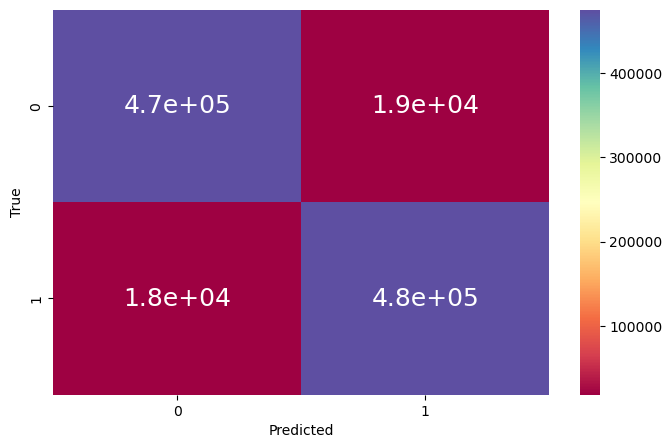

In [112]:
# Classification report
train_report = classification_report(all_labels, all_preds, target_names=[labels_map[i] for i in labels_map])

print("Classification Report:\n", train_report)

# Confusion matrix
cf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 5))
sns.heatmap(cf_matrix, annot=True, annot_kws={"size": 18}, cmap="Spectral")
plt.ylabel('True')
plt.xlabel('Predicted')

count = 1

while (True):
    if (os.path.isfile("../../trained_models/models/convnext/trained_model_" + f"{count}" + ".pth") == False):
        plt.savefig("../../trained_models/evaluation_results/convnext/model_" + f"{count - 1}" + "_classification_report.png") # Save the graph
        break
    else:
        count += 1

plt.show()

# Generate submission file

Create a submission.csv file from the current model.

In [113]:
# Load pretrained ConvNeXt Base model
model = models.convnext_base(weights="DEFAULT")

# Freeze the backbone
for param in model.features.parameters():
    param.requires_grad = False

# Replace the classifier head with a custom one
model.classifier = nn.Sequential(
    nn.AvgPool2d(kernel_size=3, padding=1, stride=3),  
    nn.Flatten(),                 
    nn.Linear(1024, 512),         
    nn.ReLU(),                    
    nn.Dropout(0.4),  
    nn.Linear(512, 256),         
    nn.ReLU(),                    
    nn.Dropout(0.4),  
    nn.Linear(256, 128),         
    nn.ReLU(),                    
    nn.Dropout(0.4),
    nn.Linear(128, 2),              
)

# Load model
model.load_state_dict(torch.load(current_model_path)) # load the trained model
model = model.to(device)

/tmp/ipykernel_142851/1100426771.py:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(current_model_path)) # load the trained model


In [114]:
predictions = [] # A list for storing the results

In [115]:
# Open a new CSV file for writing predictions
with open("../../submission/submission.csv", "w") as submission_file:
    # Write the header
    submission_file.write("id,label\n")

    model.eval()  # Set the model to evaluation mode
    
    with torch.no_grad():
        ids = []  # Initialize the list to hold image IDs
        predictions = []  # Initialize the list for predictions
        
        for data in test_loader:
            inputs = data[0]
            inputs = inputs.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            # Map predictions to labels
            batch_predictions = [labels_map[p.item()] for p in predicted]
            batch_ids = [("test_data_v2/" + image_id) for image_id in data[1]]  # Collect image IDs from the batch
            
            # Append the current batch's predictions and ids
            ids.extend(batch_ids)
            predictions.extend(predicted)

        # Write each prediction to the file
        for img_id, pred_label in zip(ids, predictions):
            submission_file.write(f"{img_id},{pred_label}\n")

print("Submission file has been created successfully!")

Submission file has been created successfully!
